# Introduction

In this notebook I perform analysis to assess how similar the left and right-hand side data are to each other, for each user:
1. Time-Lagged Cross Correlation Analysis, which looks at the linear correlation between two signals at different lags. This measure, however, assumes stationarity of the whole time series, i.e., the average does not depend on time. This assumption is most likely not satisfied by our data.
2. Detrended-cross correlation analysis. Here, I consider the max correlation achieved in the analysis (which is performed over different lags). This measure is data-independent, corrects for non-stationarity in the timeseries, which might indeed skew traditional cross-correlation. For reference on the method, see [1] and [2].
3. Coherence Analysis, which allows to see which frequencies interact the most between two signals. However, even in this setting, non-stationary time series might create problems, see [3].
4. Dynamic Time Warping Distance. This, however, is a distance, and as such is problem dependent. It is not very clear how to compare DTWD between BVP and EDA signals.

--- 
*References*

[1] Podobnik, Boris, and H. Eugene Stanley. "Detrended cross-correlation analysis: a new method for analyzing two nonstationary time series." Physical review letters 100.8 (2008): 084102.

[2] Shen, Chenhua. "Analysis of detrended time-lagged cross-correlation between two nonstationary time series." Physics Letters A 379.7 (2015): 680-687.

[3] White, Langford B., and Boualem Boashash. "Cross spectral analysis of nonstationary processes." IEEE Transactions on Information Theory 36.4 (1990): 830-835.

# Data Loading

In [14]:
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/usilaughs/filtered/*/ACC/*.parquet"
bvp_data_base_path: str = "../data.nosync/usilaughs/filtered/*/BVP/*.parquet"

eda_data_paths: list[str] = glob(eda_data_base_path)
acc_data_paths: list[str] = glob(acc_data_base_path)
eda_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
)
for file in tqdm(eda_data_paths, desc="Loading EDA data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    eda_data[side_name][user_name] = read_parquet(file)
    
   
acc_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
) 
for file in tqdm(acc_data_paths, desc="Loading ACC data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    acc_data[side_name][user_name] = read_parquet(file)

# bvp_data = None


bvp_data_paths: list[str] = glob(bvp_data_base_path)
bvp_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
)
for file in tqdm(bvp_data_paths, desc="Loading BVP data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    bvp_data[side_name][user_name] = read_parquet(file)
    
    
physiological_data: dict[str, defaultdict[str, defaultdict[str, Series]]] = {
    "EDA": eda_data,
    "BVP": bvp_data,
    'ACC': acc_data,
}
del eda_data
del bvp_data
del acc_data
garbage_collect()

Loading EDA data:   0%|          | 0/67 [00:00<?, ?it/s]

Loading ACC data:   0%|          | 0/68 [00:00<?, ?it/s]

Loading BVP data:   0%|          | 0/68 [00:00<?, ?it/s]

4034

# Checking Stationarity

In [10]:
from typing import Callable
from arch.unitroot import KPSS
from matplotlib.pyplot import figure, show, savefig, title
from seaborn import heatmap
from collections import defaultdict
from pandas import Series


def check_stationarity(
    physiological_data: dict[str, defaultdict[str, defaultdict[str, Series]]],
    signal: str,
    stationarity_method: Callable = KPSS,
    invert_pvalues: bool = False,
):
    users_left = physiological_data[signal]["left"].keys()
    users_right = physiological_data[signal]["right"].keys()
    user_list = list(set(users_left) & set(users_right))

    statistical_test = {
        side: {
            user: (
                stationarity_method(
                    physiological_data[signal][side][user].iloc[:, 0].values,
                ).pvalue
                if not invert_pvalues
                else 1
                - stationarity_method(
                    physiological_data[signal][side][user].iloc[:, 0].values,
                ).pvalue
            )
            if physiological_data[signal][side][user].iloc[:, 0].values.shape[0] > 0
            else None
            for user in tqdm(user_list, desc="User progress", colour="blue")
        }
        for side in ["left", "right"]
    }

    df_to_save: Series = DataFrame(statistical_test).sort_index().T

    figure(figsize=(30, 2))
    heatmap(
        df_to_save,
        xticklabels=df_to_save.columns,
        vmax=1,
        vmin=0,
        center=0,
        cmap="coolwarm",
        yticklabels=df_to_save.index,
        annot=True,
    )
    title(f"P-values of {stationarity_method.__name__} test ({signal})")
    savefig(
        f"../visualizations/{stationarity_method.__name__}_pvalues_{signal}.pdf",
        bbox_inches="tight",
    )
    show()


## EDA

In [26]:
from arch.unitroot import DFGLS, KPSS, ADF, PhillipsPerron, ZivotAndrews
signal: str = "EDA"

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

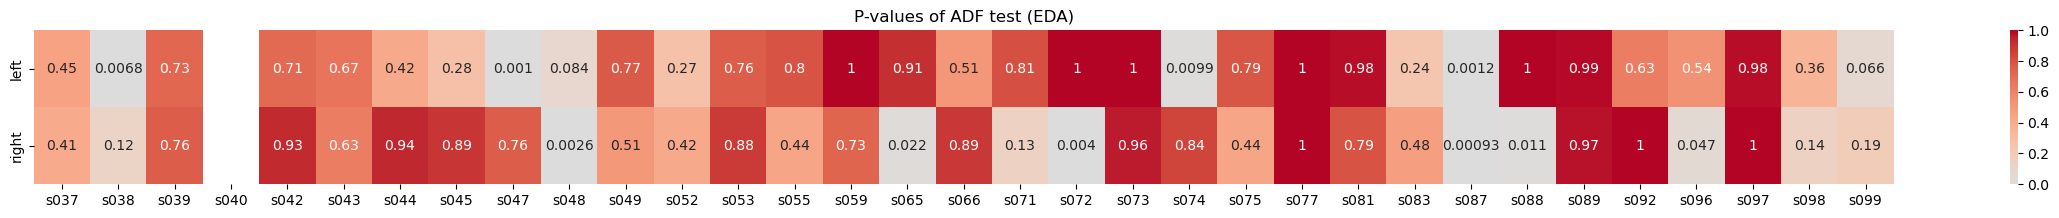

In [ ]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=False,
    stationarity_method=ADF,
)


User progress:   0%|          | 0/33 [00:00<?, ?it/s]

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

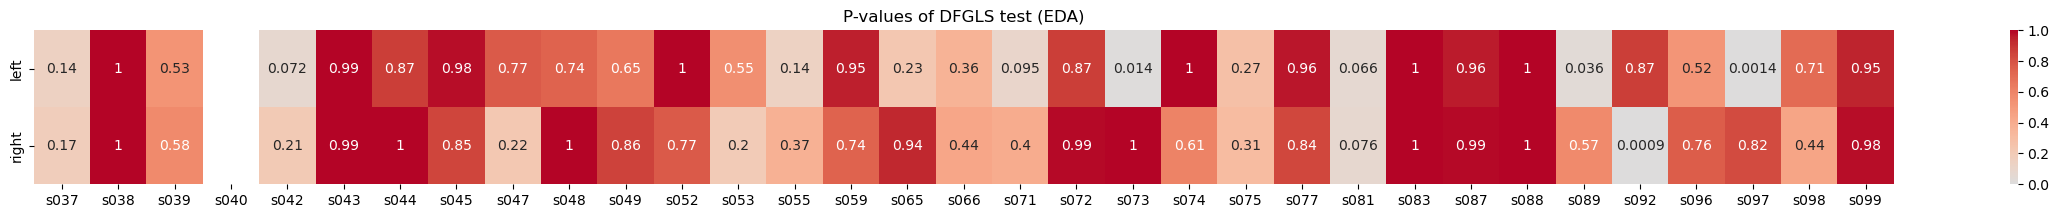

In [13]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=False,
    stationarity_method=DFGLS,
)


User progress:   0%|          | 0/33 [00:00<?, ?it/s]

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

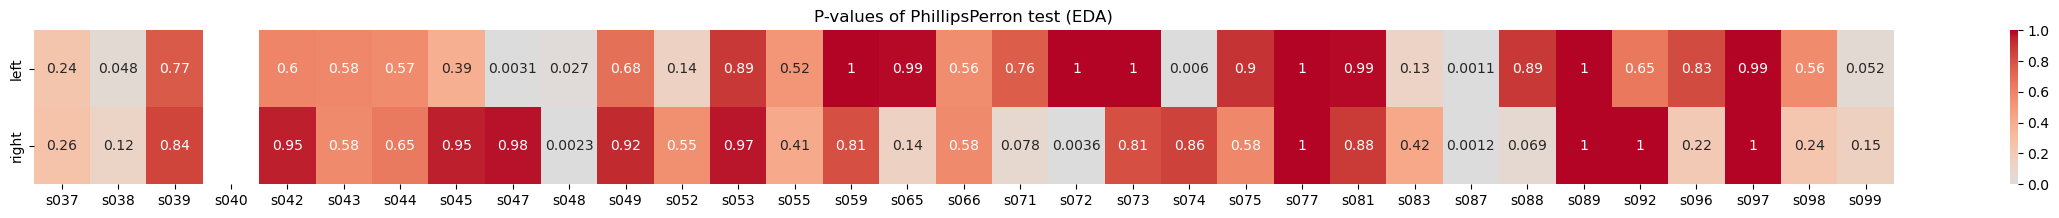

In [14]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=True,
    stationarity_method=PhillipsPerron,
)


User progress:   0%|          | 0/33 [00:00<?, ?it/s]

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

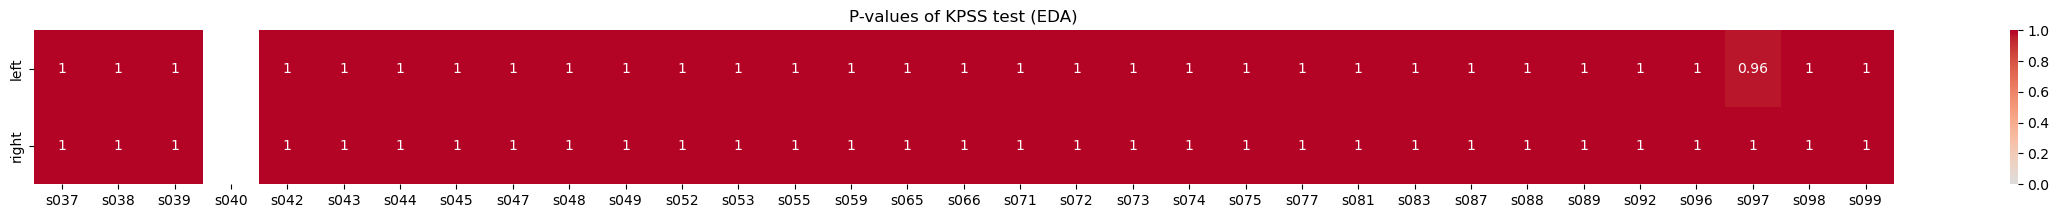

In [15]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=True,
    stationarity_method=KPSS,
)


User progress:   0%|          | 0/33 [00:00<?, ?it/s]

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

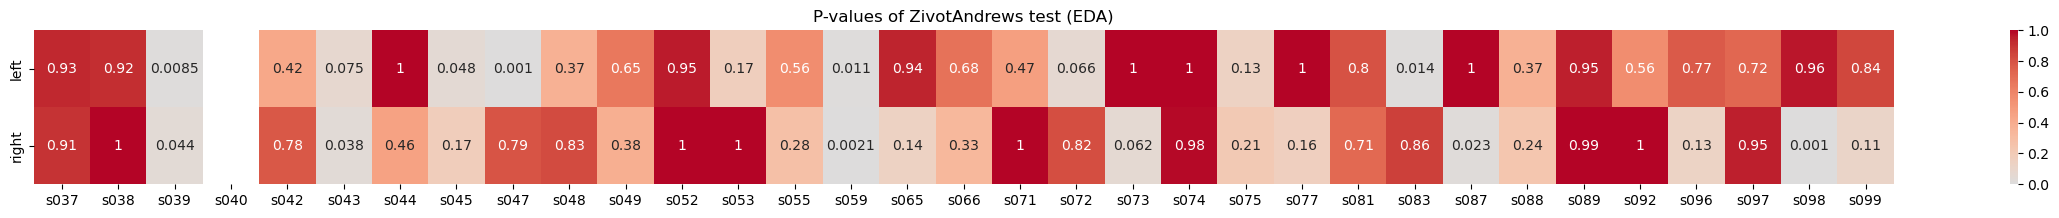

In [27]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=True,
    stationarity_method=ZivotAndrews,
)


## BVP

In [17]:
from arch.unitroot import DFGLS, KPSS, ADF, PhillipsPerron, ZivotAndrews
signal: str = "BVP"

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

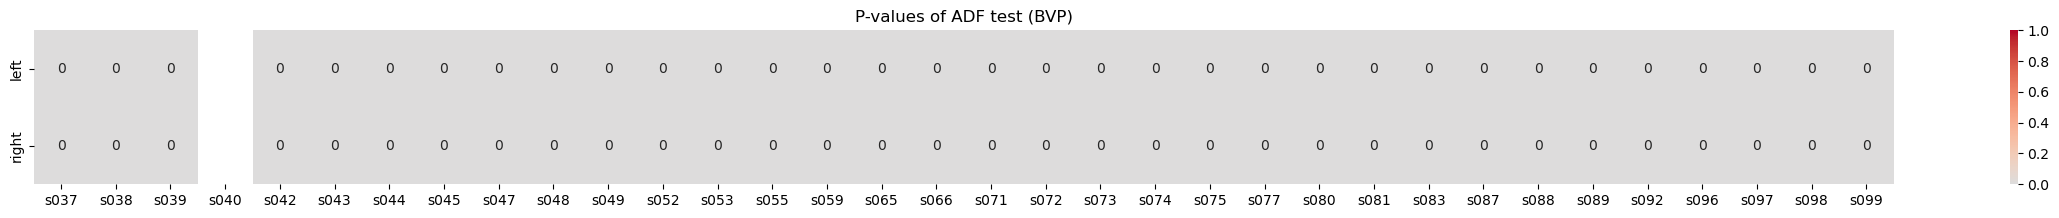

In [23]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=False,
    stationarity_method=ADF,
)


User progress:   0%|          | 0/34 [00:00<?, ?it/s]

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

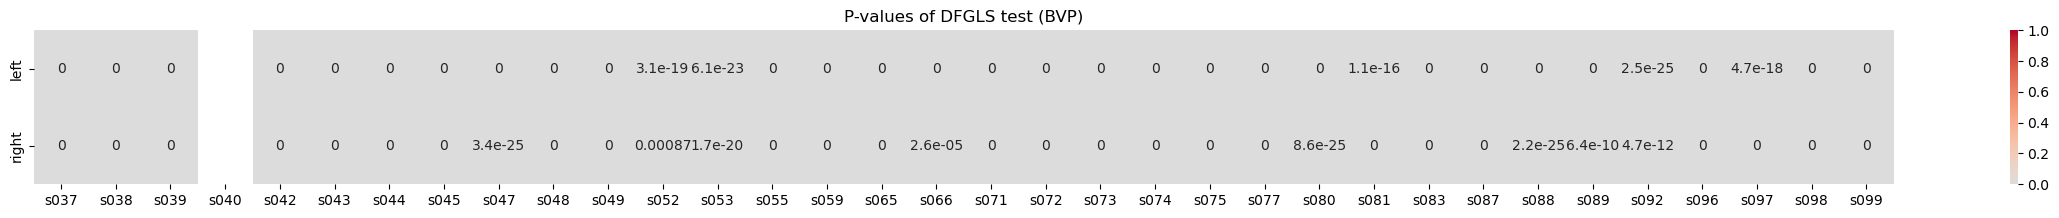

In [19]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=False,
    stationarity_method=DFGLS,
)


User progress:   0%|          | 0/34 [00:00<?, ?it/s]

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

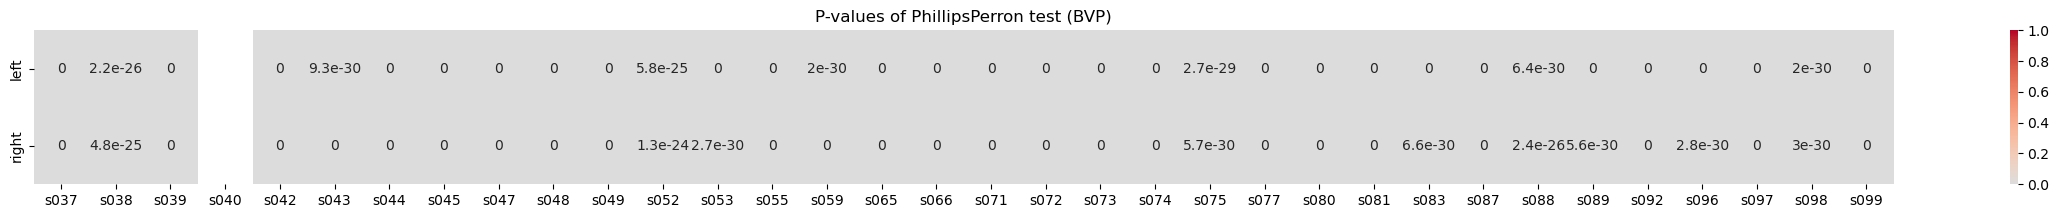

In [24]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=False,
    stationarity_method=PhillipsPerron,
)


User progress:   0%|          | 0/34 [00:00<?, ?it/s]

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

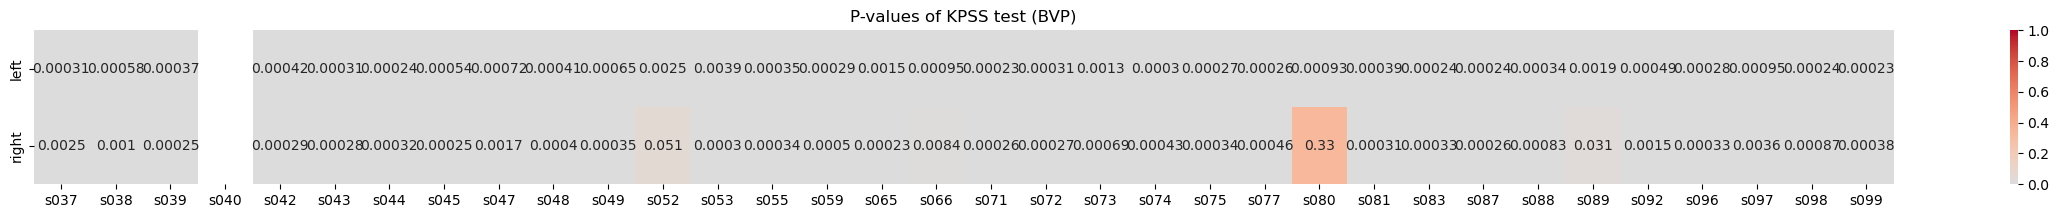

In [21]:
check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=True,
    stationarity_method=KPSS,
)


# Time-Lagged Detrended Cross-Correlation

In [11]:
from sys import path

path.append("../")
from warnings import warn

from joblib import Parallel, delayed
from numpy import nan, ndarray
from pandas import DataFrame
from tqdm.notebook import tqdm

from src.utils.dcca import detrended_correlation
from src.utils.dcca.cross_correlation import cross_correlation


def time_lagged_cross_correlation_per_user(
    right_side_data: ndarray,
    left_side_data: ndarray,
    time_scale: int | None = None,
    max_time_lag: int | None = None,
    detrended: bool = True,
    n_jobs: int = -1,
    **kwargs,
) -> list[float]:
    if max_time_lag is None:
        max_time_lag = len(right_side_data)
    # TODO: implement negative time lags

    if right_side_data.shape[0] == 0 or left_side_data.shape[0] == 0:
        warn(f'No data for current input {kwargs.get("progress_item_name", None)}')
        return []
    time_lags = range(0, max_time_lag)

    if detrended:
        if time_scale is None:
            raise ValueError(
                f"time_scale must be provided for detrended correlation. Given {time_scale}"
            )
        try:
            result = Parallel(n_jobs=n_jobs)(
                delayed(detrended_correlation)(
                    x=right_side_data,
                    y=left_side_data,
                    time_scale=time_scale,
                    time_lag=time_lag,
                )
                for time_lag in tqdm(
                    time_lags,
                    desc=f'Calculating detrended cross correlation {kwargs.get("progress_item_name", None)}',
                    colour=kwargs.get("tqdm_color", "green"),
                )
            )
        except ValueError as e:
            print(
                f"{right_side_data.shape=}, {left_side_data.shape=}, {time_scale=}, {time_lags=}"
            )
            raise e
        return result
    else:
        warn("Calculation is not parallel. n_jobs ignored.")
        return [
            cross_correlation(x=right_side_data, y=left_side_data, time_lag=time_lag)
            for time_lag in tqdm(
                time_lags,
                desc=f'Calculating cross correlation {kwargs.get("progress_item_name", None)}',
                colour=kwargs.get("tqdm_color", "green"),
            )
        ]


def perform_correlation(
    physiological_data: dict,
    signal: str,
    time_scale: int | None = None,
    detrended: bool = True,
    measure_name: str = "max dcca",
    n_jobs: int = -1,
):
    users_left = physiological_data[signal]["left"].keys()
    users_right = physiological_data[signal]["right"].keys()
    user_list = list(set(users_left) & set(users_right))
    dccas = {
        user: time_lagged_cross_correlation_per_user(
            right_side_data=physiological_data[signal]["right"][user].iloc[:, 0].values,
            left_side_data=physiological_data[signal]["left"][user].iloc[:, 0].values,
            time_scale=time_scale,
            detrended=detrended,
            max_time_lag=200,
            n_jobs=n_jobs,
            progress_item_name=user,
        )
        for user in tqdm(user_list, desc="User progress", colour="blue")
    }

    max_dccas = {
        user: max(dcca) if len(dcca) > 0 else nan for user, dcca in dccas.items()
    }

    plot_results(data=max_dccas, measure_name=measure_name, vmax=1, vmin=-1, center=0)


## EDA

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

Calculating detrended cross correlation s074:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s071:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s097:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s048:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s039:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s052:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s038:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s066:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s098:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s096:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s072:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s042:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s037:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s092:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s044:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s081:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s065:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s047:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s073:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s049:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s088:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s059:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s075:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s045:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s083:   0%|          | 0/200 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_14969/4239866153.py:31: UserWarning: No data for current input s040
  warn(f'No data for current input {kwargs.get("progress_item_name", None)}')


Calculating detrended cross correlation s043:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s077:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s089:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s087:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s055:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s053:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s099:   0%|          | 0/200 [00:00<?, ?it/s]

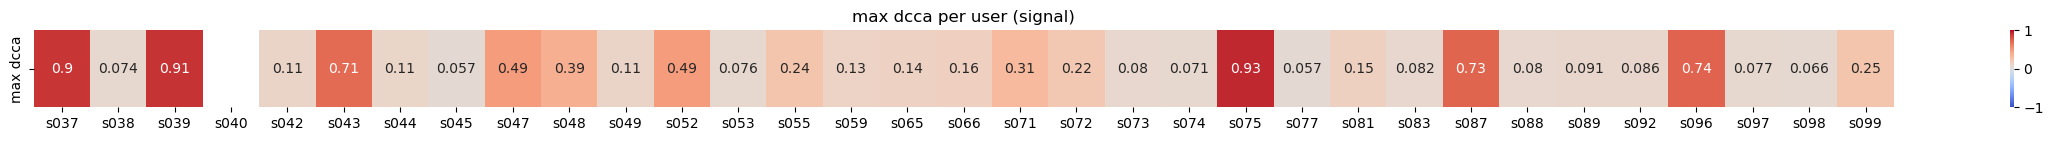

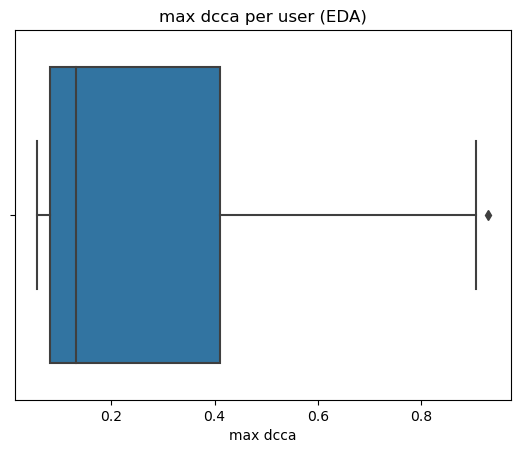

In [4]:
signal: str = "EDA"
time_scale: int = 20
perform_correlation(
    physiological_data=physiological_data,
    signal=signal,
    time_scale=time_scale,
    detrended=True,
    measure_name="max dcca",
)


## BVP

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

Calculating detrended cross correlation s074:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s071:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s097:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s048:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s039:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s052:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s038:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s066:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s098:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s096:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s072:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s042:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s037:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s092:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s044:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s081:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s065:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s080:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s047:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s073:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s049:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s088:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s059:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s075:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s045:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s083:   0%|          | 0/200 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_14969/4239866153.py:31: UserWarning: No data for current input s040
  warn(f'No data for current input {kwargs.get("progress_item_name", None)}')


Calculating detrended cross correlation s043:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s077:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s089:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s087:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s055:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s053:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation s099:   0%|          | 0/200 [00:00<?, ?it/s]

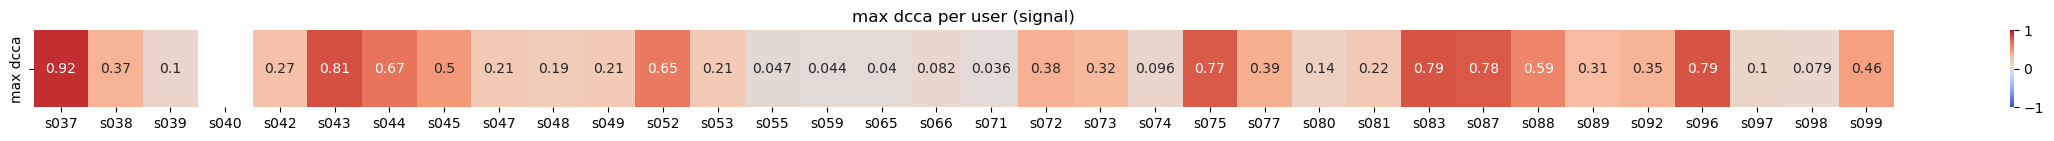

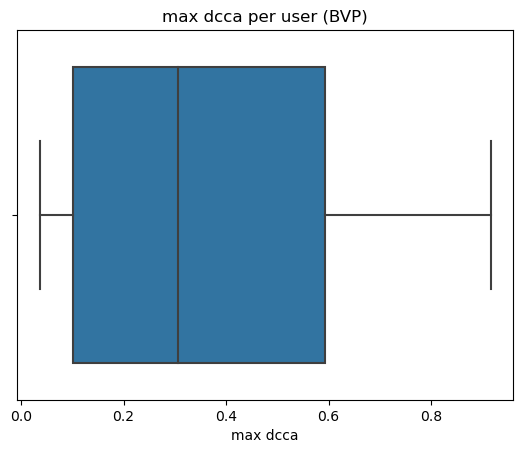

In [5]:
signal: str = "BVP"
time_scale: int = 20
perform_correlation(
    physiological_data=physiological_data,
    signal=signal,
    time_scale=time_scale,
    detrended=True,
    measure_name="max dcca",
    n_jobs=-1,
)


# Time-Lagged Cross-Correlation

## EDA

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_14969/4239866153.py:61: UserWarning: Calculation is not parallel. n_jobs ignored.
  warn("Calculation is not parallel. n_jobs ignored.")


Calculating cross correlation s074:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s071:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s097:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s048:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s039:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s052:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s038:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s066:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s098:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s096:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s072:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s042:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s037:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s092:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s044:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s081:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s065:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s047:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s073:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s049:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s088:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s059:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s075:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s045:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s083:   0%|          | 0/200 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_14969/4239866153.py:31: UserWarning: No data for current input s040
  warn(f'No data for current input {kwargs.get("progress_item_name", None)}')


Calculating cross correlation s043:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s077:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s089:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s087:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s055:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s053:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s099:   0%|          | 0/200 [00:00<?, ?it/s]

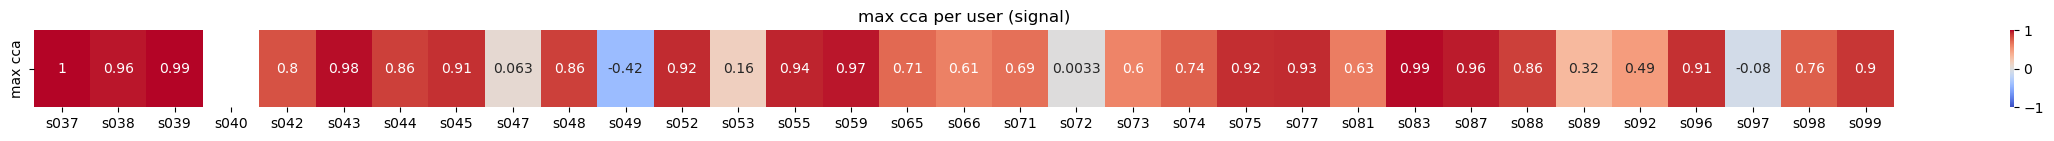

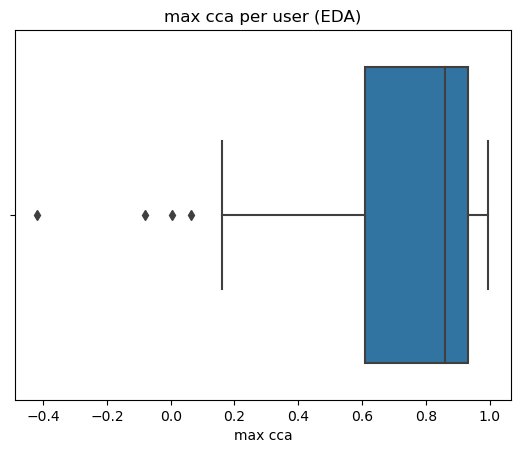

In [6]:
signal: str = "EDA"
time_scale: int = 20
perform_correlation(
    physiological_data=physiological_data,
    signal=signal,
    time_scale=time_scale,
    detrended=False,
    measure_name="max cca",
)


## BVP

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_14969/4239866153.py:61: UserWarning: Calculation is not parallel. n_jobs ignored.
  warn("Calculation is not parallel. n_jobs ignored.")


Calculating cross correlation s074:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s071:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s097:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s048:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s039:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s052:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s038:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s066:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s098:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s096:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s072:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s042:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s037:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s092:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s044:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s081:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s065:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s080:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s047:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s073:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s049:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s088:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s059:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s075:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s045:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s083:   0%|          | 0/200 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_14969/4239866153.py:31: UserWarning: No data for current input s040
  warn(f'No data for current input {kwargs.get("progress_item_name", None)}')


Calculating cross correlation s043:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s077:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s089:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s087:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s055:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s053:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s099:   0%|          | 0/200 [00:00<?, ?it/s]

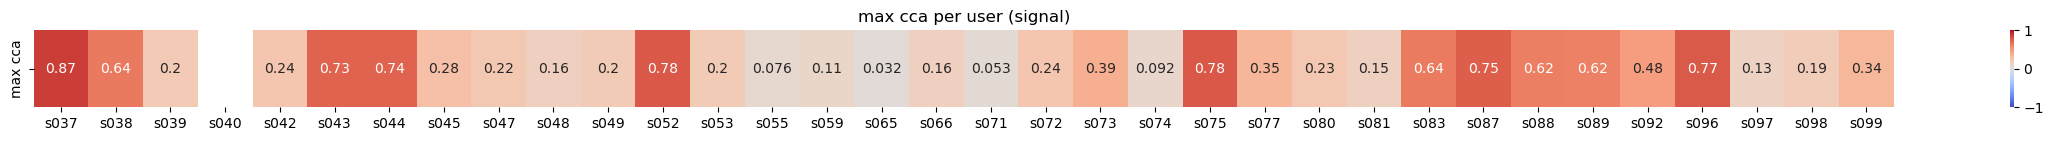

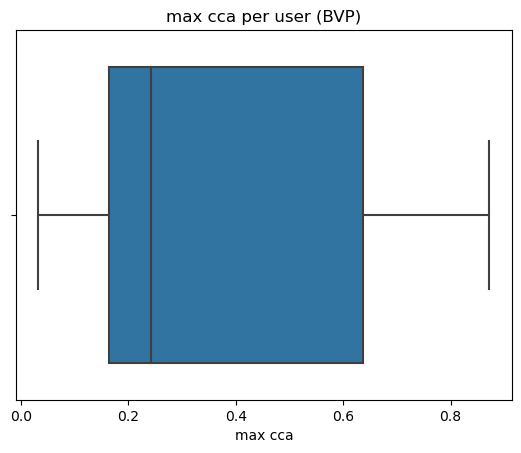

In [7]:
signal: str = "BVP"
time_scale: int = 20
perform_correlation(
    physiological_data=physiological_data,
    signal=signal,
    time_scale=time_scale,
    detrended=False,
    measure_name="max cca",
)


# Dynamic Time Warping

In [15]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sys import path
path.append("../")
from src.utils.plots import plot_heatmap_boxplot

In [28]:
def run_dtw_calculation(physiological_data: dict, signal: str, n_jobs: int = -1, **kwargs):
    users_left = physiological_data[signal]["left"].keys()
    users_right = physiological_data[signal]["right"].keys()
    user_list = list(set(users_left) & set(users_right))

    # Define a function that takes in a user and computes the DTW distance
    def compute_dtw(user, physiological_data, signal):
        x = physiological_data[signal]["right"][user].iloc[:, 0].values.reshape(-1, 1)
        y = physiological_data[signal]["left"][user].iloc[:, 0].values.reshape(-1, 1)
        return user, fastdtw(x=x, y=y, dist=kwargs.get("distance", euclidean))[0]

    # Use Parallel and delayed to run the function in parallel
    dtws = Parallel(n_jobs=n_jobs)(
        delayed(compute_dtw)(user, physiological_data, signal)
        for user in tqdm(user_list, desc="User progress", colour="blue")
    )

    # Convert the results to a dictionary
    return dict(dtws)


## EDA

In [32]:
signal: str = "EDA"
dtws = run_dtw_calculation(physiological_data=physiological_data, signal=signal, n_jobs=1)

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

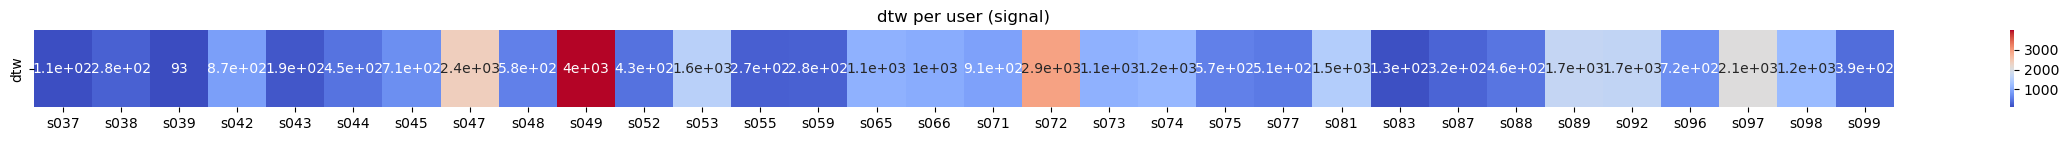

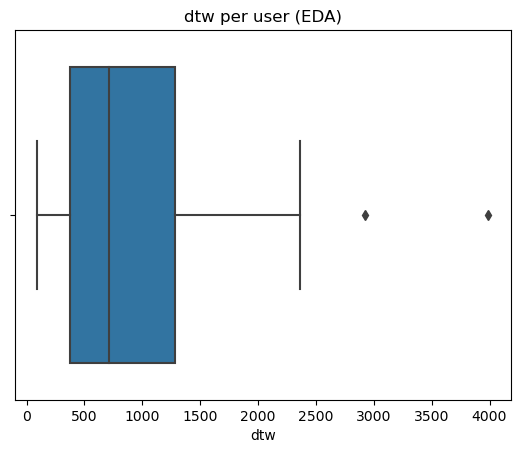

In [33]:
dtws = {user: dtw for user, dtw in dtws.items() if dtw > 0}
plot_heatmap_boxplot(
    data=dtws, signal=signal, measure_name="dtw", vmax=None, vmin=None, center=None
)


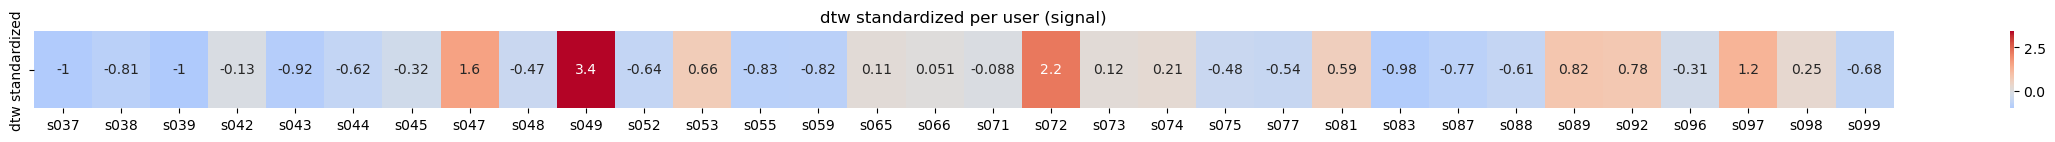

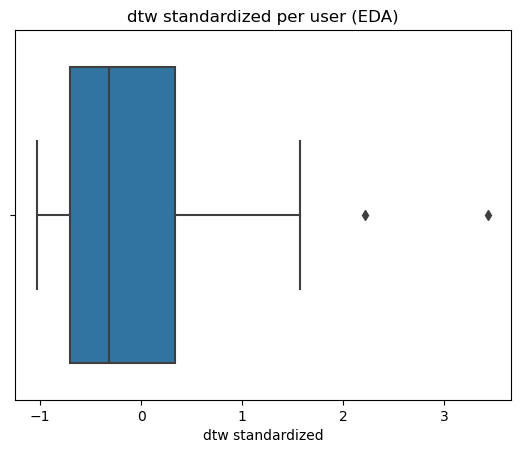

In [34]:
from numpy import nanmean, nanstd

dtws = {user: dtw for user, dtw in dtws.items() if dtw > 0}
dtws_stand = {
    user: (dtw - nanmean(list(dtws.values()))) / nanstd(list(dtws.values()))
    for user, dtw in dtws.items()
}
plot_heatmap_boxplot(
    data=dtws_stand,
    signal=signal,
    measure_name="dtw standardized",
    vmax=None,
    vmin=None,
    center=0,
)


## BVP

In [36]:
signal: str = "BVP"
dtws = run_dtw_calculation(physiological_data=physiological_data, signal=signal, n_jobs=-1)

User progress:   0%|          | 0/34 [00:00<?, ?it/s]

/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


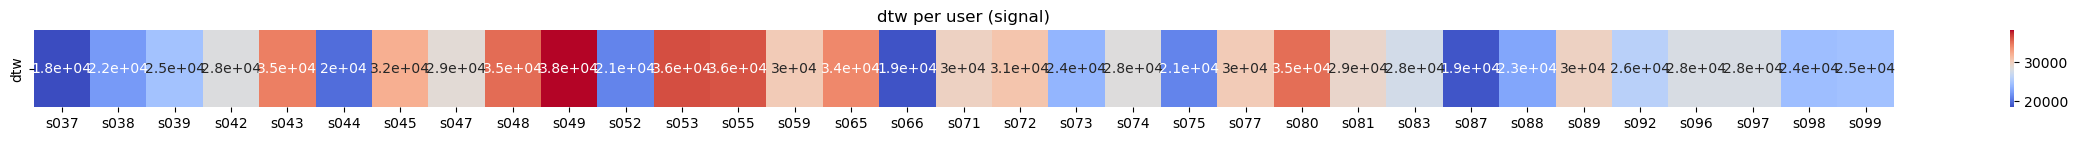

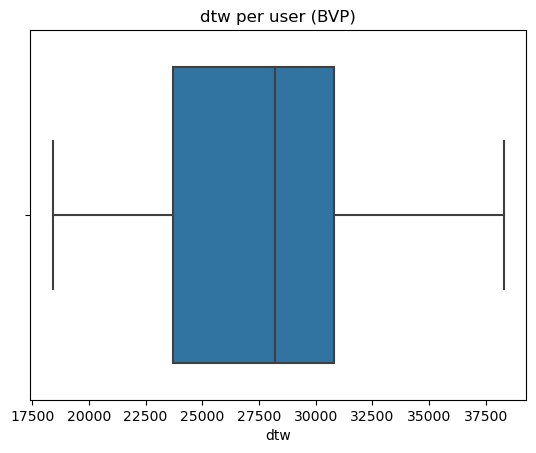

In [37]:
dtws = {user: dtw for user, dtw in dtws.items() if dtw > 0}
plot_heatmap_boxplot(
    data=dtws, signal=signal, measure_name="dtw", vmax=None, vmin=None, center=None
)


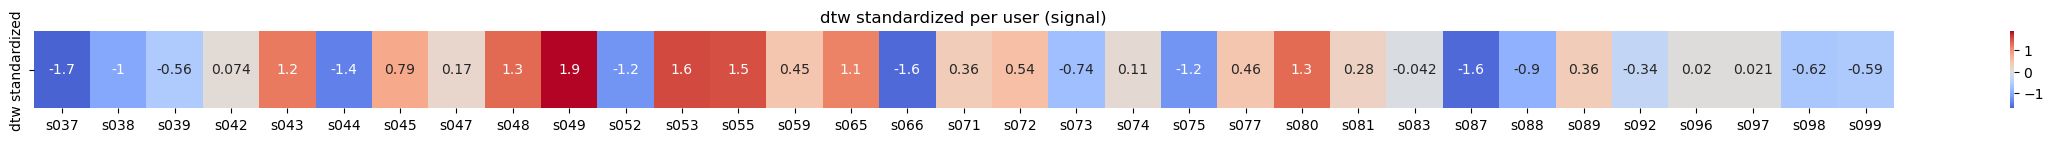

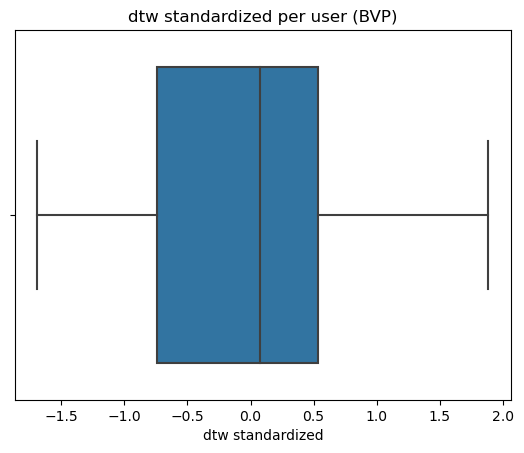

In [38]:
from numpy import nanmean, nanstd

dtws = {user: dtw for user, dtw in dtws.items() if dtw > 0}
dtws_stand = {
    user: (dtw - nanmean(list(dtws.values()))) / nanstd(list(dtws.values()))
    for user, dtw in dtws.items()
}
plot_heatmap_boxplot(
    data=dtws_stand,
    signal=signal,
    measure_name="dtw standardized",
    vmax=None,
    vmin=None,
    center=0,
)

# Coherence Analysis

## EDA

In [9]:
from scipy.signal import coherence

In [60]:
signal: str = "EDA"
time_scale: int = 20
users_left = physiological_data[signal]["left"].keys()
users_right = physiological_data[signal]["right"].keys()
user_list = list(set(users_left) & set(users_right))

cas = {
    user: coherence(
        x=physiological_data[signal]["right"][user].iloc[:, 0].values,
        y=physiological_data[signal]["left"][user].iloc[:, 0].values,
        fs=1.,
        window='hann',
        nperseg=None,
        noverlap=None,
        nfft=None,
        detrend='constant',
        axis=-1,
    )
    for user in tqdm(user_list, desc="User progress", colour='blue')
}


User progress:   0%|          | 0/33 [00:00<?, ?it/s]

In [61]:
max_cca = {user: ca[1].max() for user, ca in cas.values() if len(ca[1]) > 0}

TypeError: object of type 'numpy.float64' has no len()

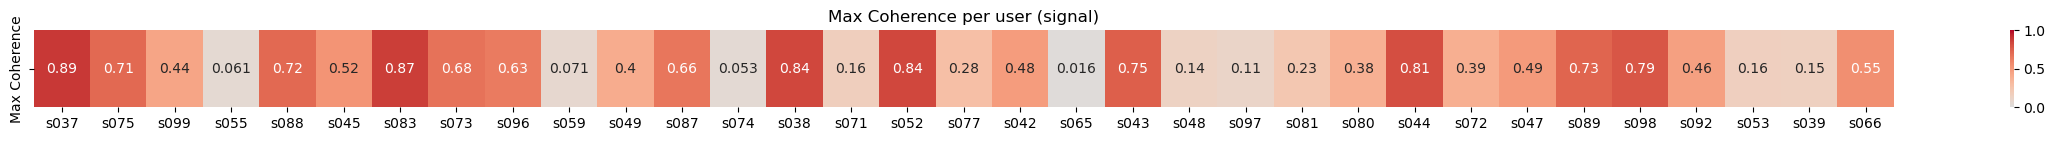

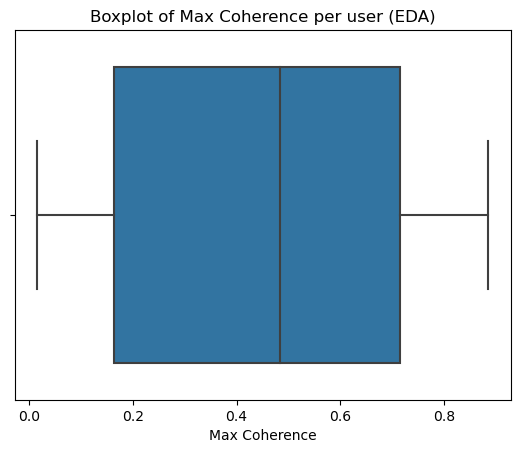

In [62]:
from matplotlib.pyplot import figure, show, savefig, title
from seaborn import heatmap


df_to_save: Series = Series(max_cca)
df_to_save = DataFrame(df_to_save, columns=['Max Coherence']).T

figure(figsize=(30, 1))
heatmap(
    df_to_save,
    xticklabels=df_to_save.columns,
    center=0,
    vmax=1,
    vmin=0,
    cmap="coolwarm",
    yticklabels=df_to_save.index,
    annot=True,
)
title(f"Max Coherence per user (signal)")
savefig(f"../visualizations/user_max_cca_{signal}.pdf", bbox_inches="tight")
show()
from seaborn import boxplot


boxplot(x=df_to_save.iloc[0, :])
title(f"Boxplot of Max Coherence per user ({signal})")
savefig(f"../visualizations/user_max_cca_boxplot_{signal}.pdf", bbox_inches="tight")
show()


In [63]:
avg_cca = {user: ca[1].mean() for user, ca in cas.values() if len(ca[1]) > 0}

TypeError: object of type 'numpy.float64' has no len()

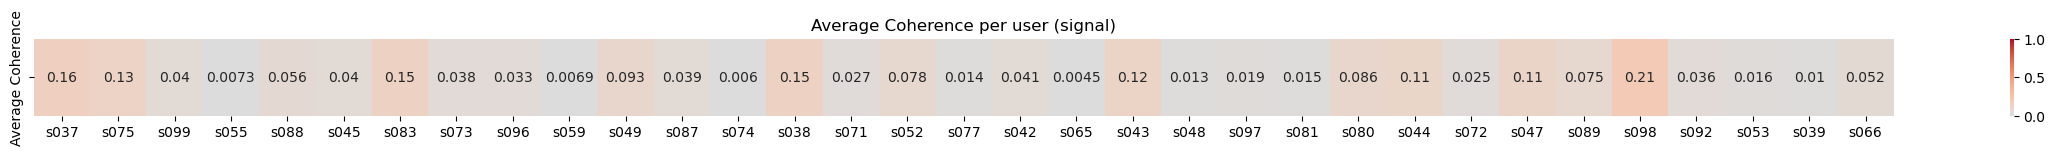

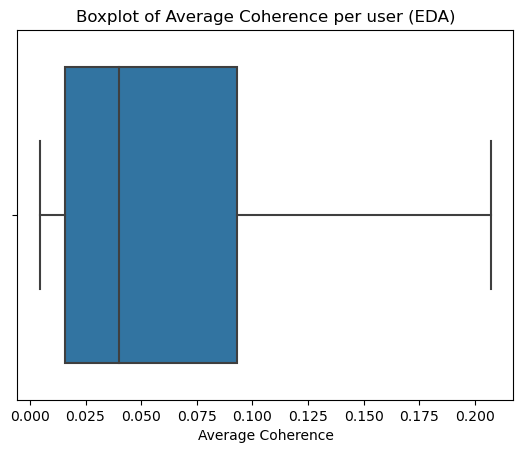

In [64]:
from matplotlib.pyplot import figure, show, savefig, title
from seaborn import heatmap


df_to_save: Series = Series(avg_cca)
df_to_save = DataFrame(df_to_save, columns=['Average Coherence']).T

figure(figsize=(30, 1))
heatmap(
    df_to_save,
    xticklabels=df_to_save.columns,
    vmax=1,
    vmin=0,
    center=0,
    cmap="coolwarm",
    yticklabels=df_to_save.index,
    annot=True,
)
title(f"Average Coherence per user (signal)")
savefig(f"../visualizations/user_average_cca_{signal}.pdf", bbox_inches="tight")
show()
from seaborn import boxplot


boxplot(x=df_to_save.iloc[0, :])
title(f"Boxplot of Average Coherence per user ({signal})")
savefig(f"../visualizations/user_average_cca_boxplot_{signal}.pdf", bbox_inches="tight")
show()


## BVP

In [65]:
from scipy.signal import coherence

In [53]:
signal: str = "BVP"
time_scale: int = 20
users_left = physiological_data[signal]["left"].keys()
users_right = physiological_data[signal]["right"].keys()
user_list = list(set(users_left) & set(users_right))

cas = {
    user: coherence(
        x=physiological_data[signal]["right"][user].iloc[:, 0].values,
        y=physiological_data[signal]["left"][user].iloc[:, 0].values,
        fs=1.,
        window='hann',
        nperseg=None,
        noverlap=None,
        nfft=None,
        detrend='constant',
        axis=-1,
    )
    for user in tqdm(user_list, desc="User progress", colour='blue')
}


User progress:   0%|          | 0/34 [00:00<?, ?it/s]

In [54]:
max_cca = {user: ca[1].max() for user, ca in cas.items() if len(ca[1]) > 0}

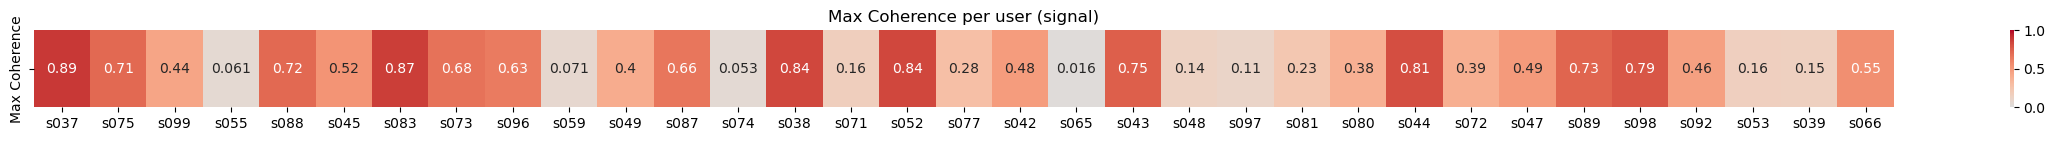

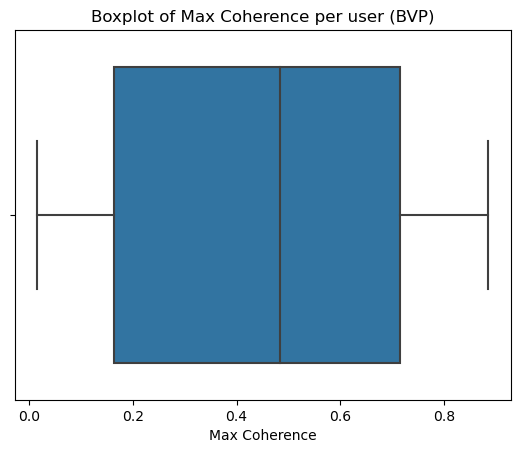

In [55]:
from matplotlib.pyplot import figure, show, savefig, title
from seaborn import heatmap


df_to_save: Series = Series(max_cca)
df_to_save = DataFrame(df_to_save, columns=['Max Coherence']).T

figure(figsize=(30, 1))
heatmap(
    df_to_save,
    xticklabels=df_to_save.columns,
    center=0,
    vmax=1,
    vmin=0,
    cmap="coolwarm",
    yticklabels=df_to_save.index,
    annot=True,
)
title(f"Max Coherence per user (signal)")
savefig(f"../visualizations/user_max_cca_{signal}.pdf", bbox_inches="tight")
show()
from seaborn import boxplot


boxplot(x=df_to_save.iloc[0, :])
title(f"Boxplot of Max Coherence per user ({signal})")
savefig(f"../visualizations/user_max_cca_boxplot_{signal}.pdf", bbox_inches="tight")
show()


In [58]:
avg_cca = {user: ca[1].mean() for user, ca in cas.items() if len(ca[1]) > 0}

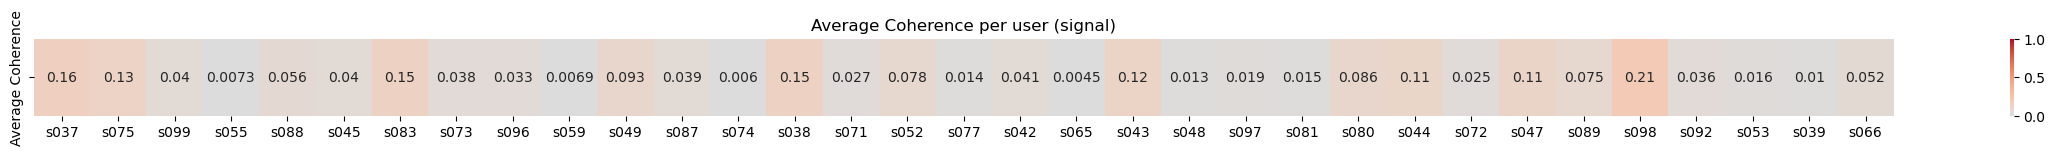

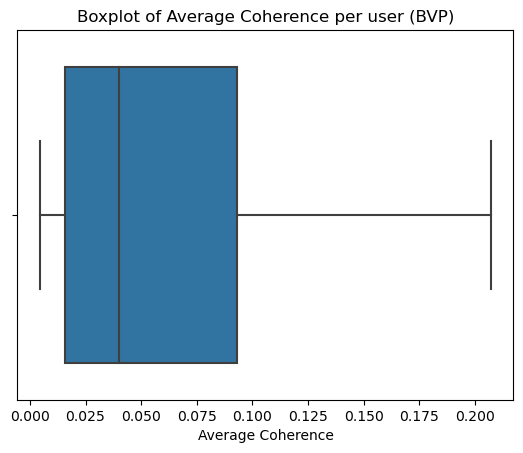

In [59]:
from matplotlib.pyplot import figure, show, savefig, title
from seaborn import heatmap


df_to_save: Series = Series(avg_cca)
df_to_save = DataFrame(df_to_save, columns=['Average Coherence']).T

figure(figsize=(30, 1))
heatmap(
    df_to_save,
    xticklabels=df_to_save.columns,
    vmax=1,
    vmin=0,
    center=0,
    cmap="coolwarm",
    yticklabels=df_to_save.index,
    annot=True,
)
title(f"Average Coherence per user (signal)")
savefig(f"../visualizations/user_average_cca_{signal}.pdf", bbox_inches="tight")
show()
from seaborn import boxplot


boxplot(x=df_to_save.iloc[0, :])
title(f"Boxplot of Average Coherence per user ({signal})")
savefig(f"../visualizations/user_average_cca_boxplot_{signal}.pdf", bbox_inches="tight")
show()
